## Import Packages and Dataset

In [65]:
# Import statements (make sure all packages intalled prior to running)
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
df = pd.read_csv("Data_Washington Fatal Crash Survey.csv", low_memory=False)

In [ ]:
from arcgis.geocoding import reverse_geocode
from arcgis.geometry import Geometry
from arcgis.gis import GIS


## Derive zip code for crashes 

Method: Reverse geocoding with ArcGIS and impute any missing zipcode values

In [ ]:
# long : x
# lat : y

# driver zip code : dzip 
df.rename(columns={'x': 'lon', 'y': 'lat'}, inplace=True)

In [ ]:
gis = GIS(api_key="AAPK206d8c337d5a416ca8a7824330c0ca7bkQWmIxSD8K5_qxX1ly5btaWLcl36cVX_1iDwCQxl_IgY56Zh6TN-Usx26i4oM77l")
# exposed for now

def get_zip(df,lon_field, lat_field):
    location = reverse_geocode((Geometry({"x":float(df[lon_field]),"y":float(df[lat_field]), "spatialReference":{"wkid":4326}})))
    return location['address']['Postal']

df['crashzip'] = df.apply(get_zip, axis=1, lat_field='lat', lon_field='lon')

In [ ]:
# update missing crash zip values in df 
# case 78 03/18/2020 in county 45(Pacific) --> crash lat long improperly recorded  78.304936,  -778.304936 impossible! city = unincorporated
# FOREST SERVICES RD 2300 is not an actual road... should we drop the row?
# case 349 09/12/2021 in county 5 --> zip: 99352 could not be identified by arcGIS identified using haversine distance
# case 638 09/05/2021 in county 19(Ferry) --> lat long recorded as 78.304936,  -778.304936 impossible! city = unincorporated
# Ferry county is on a reservation in the middle of nowhere next to a natl forest far northeast of WA 
# crash occurred on BRIDGE CREEK RD in Ferry County --> brute force zip: 99138

df.loc[3690,"crashzip"] = 99352
df.loc[4128,"crashzip"] = 99138

In [ ]:
# saved because computationally expensive 
# don't want to call API every time we run the code 
# DONT RUN THAT PART 

df.to_csv('crashdata_updated.csv') # import THIS data set

## What proportion of drivers are involved in fatal crashes crash in communities where they live?

Method: Calculate proportion mathematically

In [2]:
# start running code from here

data = pd.read_csv("crashdata_updated.csv", low_memory=False) # some cols have mixed dtypes...
data["crash_dt"]= pd.to_datetime(data["crash_dt"])
data["licstate"]= data["licstate"].astype(str)

# Among drivers involved in fatal crashes, what proportion are involved in crashes in communities where they live?

# How do we want to define "community"? Let's start with zip codes
data['dzip'] = data['dzip'].astype(str)
# get rid of the trailing zeros
data['dzip'] = data['dzip'].replace(r'\.0$', '', regex=True)

In [3]:
data

,Unnamed: 0,year,case,par,repjur,crash_dt,crash_tm,accday,accmon,holiday,...,lab,isedtcase,crf1,crf2,crf3,CoRoadName,CoMP,IntCoRoadName,IntCoMP,crashzip
0,0,2017,1,E628946,2.0,2017-01-01,2:12,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98201
1,1,2017,2,E627989,26.0,2017-01-02,17:14,2,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98359
2,2,2017,4,3747633,263.0,2017-01-01,18:47,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98103
3,3,2017,5,E628691,4.0,2017-01-01,3:50,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99224
4,4,2017,6,3746306,263.0,2017-01-05,9:53,5,1,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4127,4127,2021,636,Incid08,334.0,2021-08-08,9:38,8,8,NaN,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,99116
4128,4128,2021,638,Incid09,334.0,2021-09-05,1:36,5,9,NaN,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,99138
4129,4129,2021,639,EB48605,263.0,2021-04-21,17:32,21,4,NaN,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,98144
4130,4130,2021,639,EB48605,263.0,2021-04-21,17:32,21,4,NaN,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,98144


In [4]:
# In order for this calculation to be accurate, we need to remove the rows where BOTH zip code and state is "unknown" or "not reported" because the driver zip for each of these rows won't match the crash zip but we have no way validating where the driver is ACTUALLY from-- we cannot assume that the driver is from out of state/country 

# Answers hinge on the assumption that the driver's zip code for each observation is accurate 
for index, row in data.iterrows():
    if row['dzip']=='99999' and row['licstate']=='99':
        data.drop(index, inplace=True)
    if row['dzip']=='99999' and row['licstate']=='98':
        data.drop(index, inplace=True)
    if row['dzip']=='99998' and row['licstate']=='99':
        data.drop(index, inplace=True)
    if row['dzip']=='99998' and row['licstate']=='98':
        data.drop(index, inplace=True)
    if row['dzip']=='99998' and row['licstate']=='53':
        data.drop(index, inplace=True)

In [5]:
# should be done

data.reset_index(inplace=True)

In [6]:
# For the crashes where driver's zip is "unknown" (99999) but state is known --> ok to keep since they are out of state
print(data[['licstate','dzip']].iloc[1359], "State/Country=Alabama") # index 1359 licstate = 1 (ALABAMA) 
print(data[['licstate','dzip']].iloc[984], "State/Country = Canada") # index 984 licstate = 95 (CANADA) No ZIP 

licstate        1
dzip        99999
Name: 1359, dtype: object State/Country=Alabama
licstate       95
dzip        99999
Name: 984, dtype: object State/Country = Canada


## Recalculate proportions of drivers from outside community, but this time community = city

In [7]:
# Source: https://github.com/scpike/us-state-county-zip
citydata = pd.read_csv("geo-data.csv")

In [8]:
# match city to zip codes

def matchcity(df, dct):
    dct = dict(zip(citydata['zipcode'], citydata['city']))
    df['dcity']=df['dzip'].map(dct).fillna('00') # map over df 
    df['crashcity']=df['crashzip'].map(dct).fillna('00') # map over df 
    return df

In [9]:
citydict = dict(zip(citydata['zipcode'], citydata['city']))

# call our function 
matchcity(data, citydict)

,index,Unnamed: 0,year,case,par,repjur,crash_dt,crash_tm,accday,accmon,...,crf1,crf2,crf3,CoRoadName,CoMP,IntCoRoadName,IntCoMP,crashzip,dcity,crashcity
0,0,0,2017,1,E628946,2.0,2017-01-01,2:12,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98201,Everett,Everett
1,1,1,2017,2,E627989,26.0,2017-01-02,17:14,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98359,Tacoma,Olalla
2,2,2,2017,4,3747633,263.0,2017-01-01,18:47,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98103,Seattle,Seattle
3,3,3,2017,5,E628691,4.0,2017-01-01,3:50,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99224,Mead,Spokane
4,4,4,2017,6,3746306,263.0,2017-01-05,9:53,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98104,Snoqualmie,Seattle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026,4127,4127,2021,636,Incid08,334.0,2021-08-08,9:38,8,8,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,99116,Nespelem,Coulee dam
4027,4128,4128,2021,638,Incid09,334.0,2021-09-05,1:36,5,9,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,99138,Inchelium,Inchelium
4028,4129,4129,2021,639,EB48605,263.0,2021-04-21,17:32,21,4,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,98144,Lacey,Seattle
4029,4130,4130,2021,639,EB48605,263.0,2021-04-21,17:32,21,4,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,98144,Seattle,Seattle


In [19]:
print("The proportion of drivers involved in fatal crashes in communities where they don't live = %1.4f" % (len(data.query('dcity != crashcity'))/len(data)))
print("The proportion of drivers involved in fatal crashes in communities where they live = %1.4f" % (len(data.query('dcity == crashcity'))/len(data)))

The proportion of drivers involved in fatal crashes in communities where they don't live = 0.6889
The proportion of drivers involved in fatal crashes in communities where they live = 0.3111


In [21]:
# Create a categorical variable to represent whether driver is local resident or visitor
# "resident" = local resident
# "visitor" = out of town

drive_res = [] # set empty list 
for index, row in data.iterrows():
    if row['dzip']==row['crashzip']:
        drive_res.append("resident") # if equal add "resident" to list
    else:
        drive_res.append("visitor") # else add "visitor"
        
data["d_res"] = drive_res # cast list as df column

In [22]:
# Create a categorical variable to represent whether driver is local resident or visitor
# "resident" = local resident
# "visitor" = out of town

### BASED ON CITY MATCH

city_res = [] # set empty list 
for index, row in data.iterrows():
    if row['dcity']==row['crashcity']:
        city_res.append("resident") # if equal add "resident" to list
    else:
        city_res.append("visitor") # else add "visitor"
        
data["d_cty"] = city_res # cast list as df column

# "d_cty" : classifies driver as resident or visitor by CITY 
# "d_res" : classifies driver as resident or visitor by ZIP

In [23]:
print(data.groupby(data.crash_dt.dt.year)['d_cty'].value_counts())

crash_dt  d_cty   
2017      visitor     562
          resident    235
2018      visitor     530
          resident    213
2019      visitor     541
          resident    245
2020      visitor     517
          resident    272
2021      visitor     627
          resident    289
Name: d_cty, dtype: int64


 ### Recalculating proportions of crashes with visitors vs. residents for pre and post-pandemic

- Calculate the same proportions for before Spring 2020 and after Spring 2020
- Represent these 3 proportions in a horizontal stacked bar chart 

In [93]:
# Add another column to dataset indicating if it is pre or post covid (covid is in post-covid)
# Post-Covid is defined as March 1 2020, as the Governor of Washington declared a state of emergency on Feb 29, 2020

covid = [] # set empty list 
startdate = pd.to_datetime("2020-3-1").date()

for index, row in data.iterrows():
    if row['crash_dt']<startdate:
        covid.append("pre-pandemic") # if equal add "resident" to list
    else:
        covid.append("post-pandemic") # else add "visitor"
        
data["covid"] = covid # cast list as df column

In [105]:
# Pre-pandemic
print("Pre-pandemic, the proportion of drivers involved in fatal crashes \nin communities where they don't live = %1.4f" % (len(data[data['covid'] == "pre-pandemic"].query('dcity != crashcity'))/len(data[data['covid'] == "pre-pandemic"])))
print("Pre-pandemic, the proportion of drivers involved in fatal crashes \nin communities where they live = %1.4f" % (len(data[data['covid'] == "pre-pandemic"].query('dcity == crashcity'))/len(data[data['covid'] == "pre-pandemic"])))

# Post-pandemic
print("Post-pandemic, the proportion of drivers involved in fatal crashes \nin communities where they don't live = %1.4f" % (len(data[data['covid'] == "post-pandemic"].query('dcity != crashcity'))/len(data[data['covid'] == "post-pandemic"])))
print("Post-pandemic, the proportion of drivers involved in fatal crashes \nin communities where they live = %1.4f" % (len(data[data['covid'] == "post-pandemic"].query('dcity == crashcity'))/len(data[data['covid'] == "post-pandemic"])))

Pre-pandemic, the proportion of drivers involved in fatal crashes 
in communities where they don't live = 0.7038
Pre-pandemic, the proportion of drivers involved in fatal crashes 
in communities where they live = 0.2962
Post-pandemic, the proportion of drivers involved in fatal crashes 
in communities where they don't live = 0.6665
Post-pandemic, the proportion of drivers involved in fatal crashes 
in communities where they live = 0.3335


## Is there a difference between types of crashes and behavior factors among residents vs visitors?

Method: Chi-Squared Test for Homogeneity between crashes among residents and visitors


In [24]:
chi1 = chi2_contingency(pd.crosstab([data.year], data.d_cty, rownames=["Year"], colnames=["Driver"], margins=True, margins_name="Total"))
print("The p-value is ={}".format(chi1.pvalue))
print("The year by year distribution of visitors vs residents involved in fatal crashes does not change significantly.")

AttributeError: 'tuple' object has no attribute 'pvalue'

In [25]:
colist = ["numfatal", "agegrp2", "trafflow", "roadclass", "urbrur", "intersect","lanedep", "oppdir", "wrongway","pv_inv","ped_inv","ht_inv","bike_inv", "mc_inv","dd_inv", "speed_inv","drowsy_inv", "drdist_inv","aid_inv","id_inv","mj_inv","fty_inv","dr_drink","dr_alc8","dr_alc7","dr_spd"]
values = []

for k in colist:
    pval=chi2_contingency(pd.crosstab(data[k],data["d_cty"], margins=True, margins_name="Total")).pvalue
    values.append(pval)
    
sig = dict(zip(colist, values))
print("All p-values:")
print(sig)
print("Signficant p-values:")
print({k:v for k, v in sig.items() if v < 0.05})

AttributeError: 'tuple' object has no attribute 'pvalue'

## Are there specific resident ZIP Codes that tend to produce higher-risk drivers that are involved in fatal crashes at a higher rate?

- We define the rate at which zip codes tend to produce higher risk drivers as the sum of drivers from each zip code divided by the 5 year span to get the average number of high risk drivers produced by a zip code per year

In [56]:
# note: we know there are 28 fatal crashes caused by drivers from CANADA

In [27]:
# rate of drivers causing fatal crashes per zipcode per year
riskrate = pd.DataFrame(data['dzip'].value_counts()/5).head(17) # 17 instead of 15 because 15,16,17 are equal

In [28]:
risky = pd.DataFrame(data.groupby(data.crash_dt.dt.year)['dzip'].value_counts())
risky.rename(columns={'dzip':'counts'},inplace=True)

In [29]:
top17 = list(riskrate.index)
risky.reset_index(inplace=True)
# get data with just top 15 highest risk zip codes

highrisk = risky[risky['dzip'].isin(top17)]
print("The top 17 zip codes that produce high risk drivers are: {}".format(top17))
# 0 is canada

The top 17 zip codes that produce high risk drivers are: ['99301', '98444', '98387', '98391', '98404', '98837', '98003', '98951', '98258', '98901', '98223', '98584', '99206', '98022', '98902', '0', '98168']


In [30]:
riskrate.reset_index(inplace=True)

In [31]:
risky['Risk']=risky['dzip'].isin(top17).astype(int)

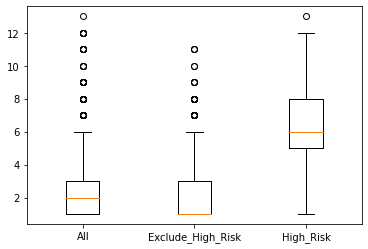

In [41]:
box = plt.boxplot([risky['counts'], risky[risky['Risk'] == 0]['counts'] , risky[risky['Risk'] == 1]['counts']], labels=['All','Exclude_High_Risk','High_Risk'])
plt.show(box)

In [42]:
# change name of 'index' to avoid errors 

riskrate.rename(columns={'index':'zipcode', 'dzip':'rate'}, inplace=True)

In [43]:
citydct = dict(zip(citydata['zipcode'], citydata['city']))
ctydct = dict(zip(citydata['zipcode'], citydata['county']))
state = dict(zip(citydata['zipcode'], citydata['state']))

# match 'city', 'county', 'state' to High Risk Zip Codes
riskrate['city']=riskrate['zipcode'].map(citydct).fillna('00') 
riskrate['county']=riskrate['zipcode'].map(ctydct).fillna('00') 
riskrate['state']=riskrate['zipcode'].map(state).fillna('00') 

In [44]:
# fill in missing except Canada
# Bonney Lake, WA Pierce 
riskrate.at[5,'city']='Bonney Lake'
riskrate.at[5,'county']='Pierce'
riskrate.at[5,'state']='Washington'

## What are the population demographics of these high-risk driver producing ZIP Codes?

The top 17 highest risk zip codes belong to 8 counties in WA state, excluding Canada. 

To analyze the demographics of high-risk producing zip codes, we examine the demographics of the county to which it belongs. We also examine how many people in each of the counties belong to high-risk zip codes. 

In [45]:
# add population size 
washpop = pd.read_csv("washpop.csv",  converters = {'Zip Code': str})

washpop.rename(columns={'Zip Code':'zipcode','Population':'population'}, inplace=True)
washpop['population'] = washpop['population'].replace(',', '', regex=True).astype(int)

In [46]:
# match ZCTA population data to zip code

population = dict(zip(washpop['zipcode'], washpop['population']))
riskrate['population']=riskrate['zipcode'].map(population).fillna('00') # map over df 

In [47]:
riskrate['county'].unique()

array(['Franklin', 'Pierce', '00', 'King', 'Yakima', 'Snohomish', 'Mason',
       'Spokane'], dtype=object)

In [48]:
riskrate['population'] = riskrate['population'].replace(',', '', regex=True).astype(int)

In [49]:
# read in population demographic data from the census
# read in median income data 

income = pd.read_csv("med_income_washco.csv")
demo = pd.read_csv("highriskdemographics.csv")

In [50]:
plots = demo.loc[demo['AGEGRP']==0]

In [51]:
labels = ['White', 'Black or African American', ' American Indian and Alaska Native','Asian',' Native Hawaiian and Other Pacific Islander', 'Hispanic', 'Two or More Races']

specs = [[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}],[{'type':'domain'}, {'type':'domain'}],[{'type':'domain'}, {'type':'domain'}]]
pies = make_subplots(rows=4, cols=2, specs=specs, subplot_titles=['Franklin', 'Grant', 'King', 'Mason', 'Pierce', 'Snohomish', 'Spokane', 'Yakima'])

In [57]:
pies.add_trace(go.Pie(labels=labels, values=[38409,  1973,   482,  2102,   200, 52240,  1670], name='Franklin'), 1, 1)
pies.add_trace(go.Pie(labels=labels, values=[52080,   931,   860,   950,   140, 42682,  1722], name='Grant'), 1, 2)
pies.add_trace(go.Pie(labels=labels, values=[1293953,  152734,   13090,  456352,   17708,  230889,  107845], name='King'), 2, 1)
pies.add_trace(go.Pie(labels=labels, values=[52239,   898,  2005,   836,   313,  7179,  2558], name='Mason'), 2, 2)

pies.add_trace(go.Pie(labels=labels, values=[596274,  66213,  10567,  63526,  15110, 109959,  61179], name='Pierce'), 3, 1)
pies.add_trace(go.Pie(labels=labels, values=[553800,  30510,   8630, 102433,   5028,  91517,  37413], name='Snohomish'), 3, 2)
pies.add_trace(go.Pie(labels=labels, values=[451633,  10205,   7576,  12610,   3225,  34603,  20848], name='Spokane'), 4, 1)
pies.add_trace(go.Pie(labels=labels, values=[106301,   2197,   9223,   2976,    211, 131130,   4495], name='Yakima'), 4, 2)

pies.update_traces(hoverinfo='label+percent+name', textinfo='none')
pies.update(layout_title_text='Populations of Counties with High Risk Zip Codes by Race',
           layout_showlegend=True)

pies = go.Figure(pies)
pies.show()

In [58]:
fig = px.bar(income, x="County", y="estinc2020", title="Median Income by County 2020")
fig.show()

In [59]:
targetzips = ['99301', '98444', '98387', '98837', '98404', '98391', '98951',
       '98003', '98901', '98223', '98258', '99206', '98584', '98022', '0',
       '98902', '98168']

newdata = data.loc[data['dzip'].isin(targetzips)]

In [60]:
len(data)

4031

In [61]:
newdata

,index,Unnamed: 0,year,case,par,repjur,crash_dt,crash_tm,accday,accmon,...,crf3,CoRoadName,CoMP,IntCoRoadName,IntCoMP,crashzip,dcity,crashcity,d_res,d_cty
13,13,13,2017,10,E632128,8.0,2017-01-08,19:05,8,1,...,NaN,NaN,NaN,NaN,NaN,98546,Shelton,Grapeview,visitor,visitor
24,24,24,2017,18,E631960,2.0,2017-01-13,18:40,13,1,...,NaN,NaN,NaN,NaN,NaN,98230,00,Blaine,visitor,visitor
25,25,25,2017,18,E631960,2.0,2017-01-13,18:40,13,1,...,NaN,NaN,NaN,NaN,NaN,98230,00,Blaine,visitor,visitor
40,40,40,2017,26,E635844,1.0,2017-01-23,17:19,23,1,...,NaN,NaN,NaN,NaN,NaN,99326,Moses lake,Connell,visitor,visitor
41,41,41,2017,26,E635844,1.0,2017-01-23,17:19,23,1,...,NaN,NaN,NaN,NaN,NaN,99326,Moses lake,Connell,visitor,visitor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4000,4098,4098,2021,622,EB35062,25.0,2021-05-29,20:32,29,5,...,NaN,244 AVE SE,0.294,NaN,NaN,98022,Enumclaw,Enumclaw,resident,resident
4018,4117,4117,2021,631,EB98551,1.0,2021-11-24,6:15,24,11,...,NaN,NaN,NaN,NaN,NaN,98932,Wapato,Granger,visitor,visitor
4020,4119,4119,2021,631,EB98551,1.0,2021-11-24,6:15,24,11,...,NaN,NaN,NaN,NaN,NaN,98932,Yakima,Granger,visitor,visitor
4022,4121,4121,2021,631,EB98551,1.0,2021-11-24,6:15,24,11,...,NaN,NaN,NaN,NaN,NaN,98932,Terrace heights,Granger,visitor,visitor


## 0.02 (17) of zip codes make up 13.5% of the fatal crashes... why?

In [62]:
data['age'].describe()

count    4031.000000
mean       43.337881
std        23.594138
min        14.000000
25%        27.000000
50%        41.000000
75%        57.000000
max       999.000000
Name: age, dtype: float64

In [63]:
newdata['age'].describe()

count    548.000000
mean      41.912409
std       17.539081
min       15.000000
25%       27.750000
50%       38.000000
75%       55.000000
max       89.000000
Name: age, dtype: float64

In [64]:
demo.loc[demo['CTYNAME']=='Yakima']

,Unnamed: 0,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,totalWA,totalBA,totalIA,totalAA,totalNA,totalH,totalTOM
133,2185,50,53,77,Washington,Yakima,2,0,256533,128596,127937,106301,2197,9223,2976,211,131130,4495
134,2186,50,53,77,Washington,Yakima,2,1,19580,9864,9716,4866,133,617,143,15,13254,552
135,2187,50,53,77,Washington,Yakima,2,2,21389,10941,10448,5366,214,681,147,12,14479,490
136,2188,50,53,77,Washington,Yakima,2,3,22578,11613,10965,5741,174,942,138,10,15103,470
137,2189,50,53,77,Washington,Yakima,2,4,19795,10126,9669,5072,129,885,144,20,13087,458
138,2190,50,53,77,Washington,Yakima,2,5,17013,8658,8355,4705,150,685,143,14,10930,386
139,2191,50,53,77,Washington,Yakima,2,6,17859,8960,8899,5971,203,648,206,16,10437,378
140,2192,50,53,77,Washington,Yakima,2,7,16537,8364,8173,6300,205,700,231,20,8793,288
141,2193,50,53,77,Washington,Yakima,2,8,15759,7935,7824,6191,164,616,258,21,8266,243
142,2194,50,53,77,Washington,Yakima,2,9,15006,7612,7394,6190,162,500,194,10,7750,200
